## 노선마다 월별 승차 인원객수

### 1. 데이터 전처리

In [4]:
import pyspark
import numpy as np
import pandas as pd

In [5]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
import pyspark.sql.types as T
import pyspark.sql.functions as F

In [6]:
pq = spark.read.parquet('all_line')
pq.show()

+----------+----------+------------+------------+------------+--------+
|  사용일자|    노선명|        역명|승차총승객수|하차총승객수|이용객수|
+----------+----------+------------+------------+------------+--------+
|2018-01-10|수인분당선|압구정로데오|       16346|       18420|   34766|
|2018-01-10|수인분당선|      서울숲|        7914|        7922|   15836|
|2018-01-10|수인분당선|        수원|        9461|        6280|   15741|
|2018-01-10|수인분당선|        수서|       15403|       15627|   31030|
|2018-01-10|수인분당선|  대모산입구|        3431|        3182|    6613|
|2018-01-10|수인분당선|      개포동|        3582|        3723|    7305|
|2018-01-10|수인분당선|        구룡|        2105|        2005|    4110|
|2018-01-10|수인분당선|        도곡|        7855|        8147|   16002|
|2018-01-10|수인분당선|        한티|       16276|       17214|   33490|
|2018-01-10|수인분당선|        선릉|       10792|       22141|   32933|
|2018-01-10|     4호선|        범계|       32318|       30961|   63279|
|2018-01-10|     4호선|        평촌|       19691|       19258|   38949|
|2018-01-10|     4호선|      인덕원| 

In [7]:
#필요없는 데이터 삭제
pq = pq.drop("하차총승객수","역명", "이용객수")
pq.show()

+----------+----------+------------+
|  사용일자|    노선명|승차총승객수|
+----------+----------+------------+
|2018-01-10|수인분당선|       16346|
|2018-01-10|수인분당선|        7914|
|2018-01-10|수인분당선|        9461|
|2018-01-10|수인분당선|       15403|
|2018-01-10|수인분당선|        3431|
|2018-01-10|수인분당선|        3582|
|2018-01-10|수인분당선|        2105|
|2018-01-10|수인분당선|        7855|
|2018-01-10|수인분당선|       16276|
|2018-01-10|수인분당선|       10792|
|2018-01-10|     4호선|       32318|
|2018-01-10|     4호선|       19691|
|2018-01-10|     4호선|       28817|
|2018-01-10|     4호선|       16093|
|2018-01-10|     4호선|        4888|
|2018-01-10|     4호선|        2297|
|2018-01-10|     4호선|        2089|
|2018-01-10|     4호선|        9809|
|2018-01-10|     4호선|        4848|
|2018-01-10|     4호선|        9162|
+----------+----------+------------+
only showing top 20 rows



In [11]:
#판다스로 변환
df = pq.select("*").toPandas()
df

,사용일자,노선명,승차총승객수
0,2018-01-10,수인분당선,16346
1,2018-01-10,수인분당선,7914
2,2018-01-10,수인분당선,9461
3,2018-01-10,수인분당선,15403
4,2018-01-10,수인분당선,3431
...,...,...,...
809438,2019-12-31,9호선,3525
809439,2019-12-31,9호선,38032
809440,2019-12-31,공항철도,15568
809441,2019-12-31,공항철도,2488


In [14]:
#사용일자 컬럼명 변경
df.rename(columns={"사용일자" : "월간사용일자"}, inplace=True)
df

,월간사용일자,노선명,승차총승객수
0,2018-01-10,수인분당선,16346
1,2018-01-10,수인분당선,7914
2,2018-01-10,수인분당선,9461
3,2018-01-10,수인분당선,15403
4,2018-01-10,수인분당선,3431
...,...,...,...
809438,2019-12-31,9호선,3525
809439,2019-12-31,9호선,38032
809440,2019-12-31,공항철도,15568
809441,2019-12-31,공항철도,2488


In [15]:
#사용일자 컬럼이 string이라서 datetime 데이터타입으로 변환해줘야함.
df['월간사용일자'] = pd.to_datetime(df['월간사용일자'])
df.dtypes

월간사용일자    datetime64[ns]
노선명               object
승차총승객수             int32
dtype: object

In [35]:
#월간사용일자와 노선명을 기준으로 그룹화
df1 = df.groupby(['월간사용일자','노선명']).sum().reset_index()
df1

,월간사용일자,노선명,승차총승객수
0,2018-01-01,1호선,772315
1,2018-01-01,2호선,700035
2,2018-01-01,3호선,309682
3,2018-01-01,4호선,393891
4,2018-01-01,5호선,250571
...,...,...,...
20530,2021-09-30,경의중앙선,193221
20531,2021-09-30,경춘선,38407
20532,2021-09-30,공항철도,88250
20533,2021-09-30,수인분당선,392568


In [86]:
#그룹화한것을 가지고 다시 노선을 기준으로 일별 이용객을 월별로 변경
df2 = df1.groupby(['노선명']).resample('m', on='월간사용일자').승차총승객수.sum().reset_index()
df2

,노선명,월간사용일자,승차총승객수
0,1호선,2018-01-31,37718857
1,1호선,2018-02-28,34000484
2,1호선,2018-03-31,42911210
3,1호선,2018-04-30,41567796
4,1호선,2018-05-31,43021069
...,...,...,...
670,우이신설선,2021-05-31,1163836
671,우이신설선,2021-06-30,1172739
672,우이신설선,2021-07-31,1068301
673,우이신설선,2021-08-31,1039654


In [87]:
#가시성을위해 월간날짜를 월단위로 변경
df2['월간사용일자'] = df2['월간사용일자'].dt.strftime("%y-%m")
df2

,노선명,월간사용일자,승차총승객수
0,1호선,18-01,37718857
1,1호선,18-02,34000484
2,1호선,18-03,42911210
3,1호선,18-04,41567796
4,1호선,18-05,43021069
...,...,...,...
670,우이신설선,21-05,1163836
671,우이신설선,21-06,1172739
672,우이신설선,21-07,1068301
673,우이신설선,21-08,1039654


In [109]:
#가시성을위해 컬럼 순서 변경
month_df = df2[["월간사용일자", "노선명", "승차총승객수"]]
month_df

,월간사용일자,노선명,승차총승객수
0,18-01,1호선,37718857
1,18-02,1호선,34000484
2,18-03,1호선,42911210
3,18-04,1호선,41567796
4,18-05,1호선,43021069
...,...,...,...
670,21-05,우이신설선,1163836
671,21-06,우이신설선,1172739
672,21-07,우이신설선,1068301
673,21-08,우이신설선,1039654


In [111]:
#이쁘게 정렬
month_df = month_df.sort_values(["월간사용일자", "노선명"]).reset_index(drop=True)
month_df

,월간사용일자,노선명,승차총승객수
0,18-01,1호선,37718857
1,18-01,2호선,45887286
2,18-01,3호선,19761386
3,18-01,4호선,23688734
4,18-01,5호선,17821981
...,...,...,...
670,21-09,경의중앙선,4760404
671,21-09,경춘선,984883
672,21-09,공항철도,2214767
673,21-09,수인분당선,9574471


In [112]:
#parquet 저장 및 확인
month_df.to_parquet("line_per_month.parquet")
pq = spark.read.parquet("line_per_month.parquet")
pq.show()

+------------+----------+------------+
|월간사용일자|    노선명|승차총승객수|
+------------+----------+------------+
|       18-01|     1호선|    37718857|
|       18-01|     2호선|    45887286|
|       18-01|     3호선|    19761386|
|       18-01|     4호선|    23688734|
|       18-01|     5호선|    17821981|
|       18-01|     6호선|    10132174|
|       18-01|     7호선|    20808674|
|       18-01|     8호선|     5451090|
|       18-01|     9호선|     9018708|
|       18-01|    경강선|      699511|
|       18-01|경의중앙선|     5514174|
|       18-01|    경춘선|     1006923|
|       18-01|  공항철도|     3061504|
|       18-01|수인분당선|    12023736|
|       18-01|우이신설선|     1115984|
|       18-02|     1호선|    34000484|
|       18-02|     2호선|    40241722|
|       18-02|     3호선|    17542544|
|       18-02|     4호선|    20940626|
|       18-02|     5호선|    15512971|
+------------+----------+------------+
only showing top 20 rows



## 2. 그래프 확인

In [181]:
#그래프 확인
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\chahn\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 50900 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\chahn\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 44036 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\chahn\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\chahn\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 50857 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\chahn\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\chahn\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51088 missing from c

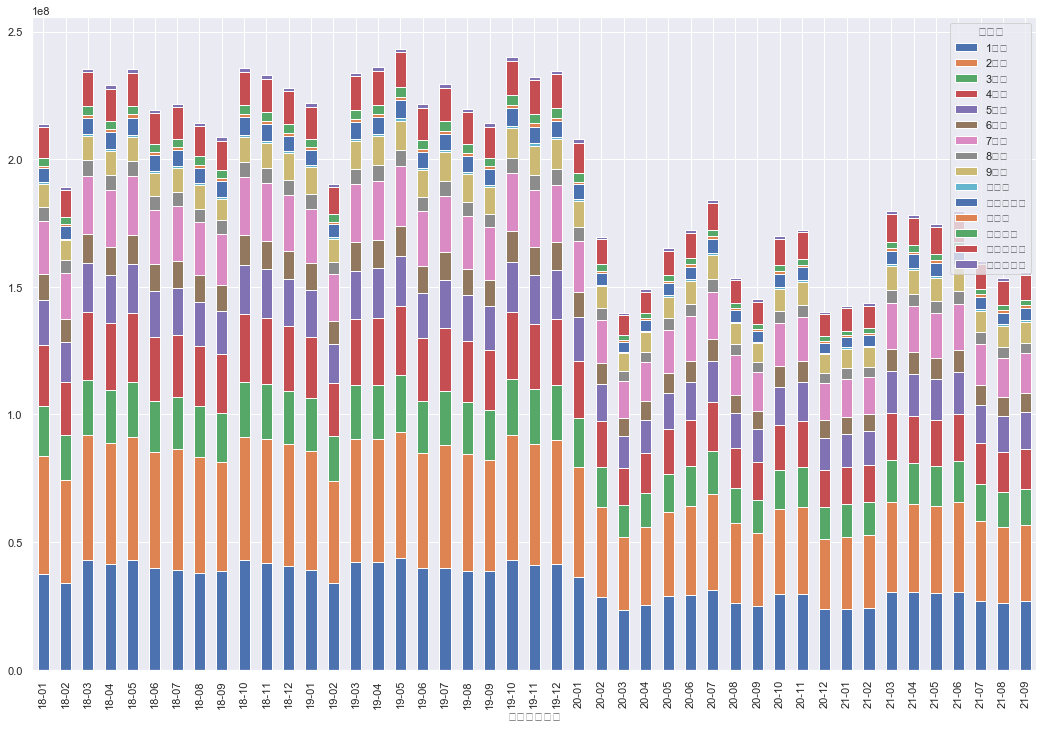

In [174]:
month_df_pivot = month_df.pivot(index="월간사용일자", columns="노선명", values="승차총승객수")
month_df_pivot.plot.bar(stacked=True, legend="False", figsize=(18,12))